In [1]:
suppressPackageStartupMessages({

    library(VariantAnnotation)
    library(tidyverse)
    library(glue)
    library(magrittr)
    library(here)
    library(bdkn)
    library(rtracklayer)

})

In [2]:
source(here("src/utils.R"))

In [3]:
snp_props <- function(gt, remove = NA) {
    snp_counts <- gt %>%
        mutate(snp = REF %+% "-" %+% ALT) %>%
        filter(!snp %in% remove) %>%
        select(-(chrom:ALT)) %>%
        group_by(snp) %>%
        summarise_all(~sum(., na.rm = TRUE))

    total_sites <-
        gt %>%
        select(-(chrom:ALT)) %>%
        summarise_all(~ sum(!is.na(.)))


    snp_props <-
        snp_counts[, -1] %>%
        colnames %>%
        map(~ snp_counts[[.x]] / total_sites[[.x]]) %>%
        setNames(colnames(snp_counts[, -1])) %>%
        as_tibble %>%
        mutate_all(~ .x / .[str_which(snp_counts$snp, "T-C")]) %>% # added to normalize by C-T proportions
        add_column(snp = snp_counts$snp, .before = 1)

    snp_props
}

In [4]:
samples <- c("denisova8", "denisova8sub", "a00", "S_French-1", "S_Dinka-1", "ustishim", "comb_neand", "elsidron1", "elsidron2")

In [5]:
exome_gt <- read_gt(here("data/vcf/merged_exome.vcf.gz"), var_only = TRUE) %>% select(chrom, pos, REF, ALT, one_of(samples))
lippold_gt <- read_gt(here("data/vcf/merged_lippold.vcf.gz"), var_only = TRUE) %>% select(chrom, pos, REF, ALT, one_of(samples))
full_gt <- read_gt(here("data/vcf/merged_full.vcf.gz"), var_only = TRUE) %>% select(chrom, pos, REF, ALT, one_of(samples))

Warning message:
“Unknown columns: `S_French-1`, `S_Dinka-1`, `elsidron2`”Warning message:
“Unknown columns: `S_French-1`, `S_Dinka-1`, `elsidron1`”Warning message:
“Unknown columns: `S_French-1`, `S_Dinka-1`, `elsidron1`, `elsidron2`”

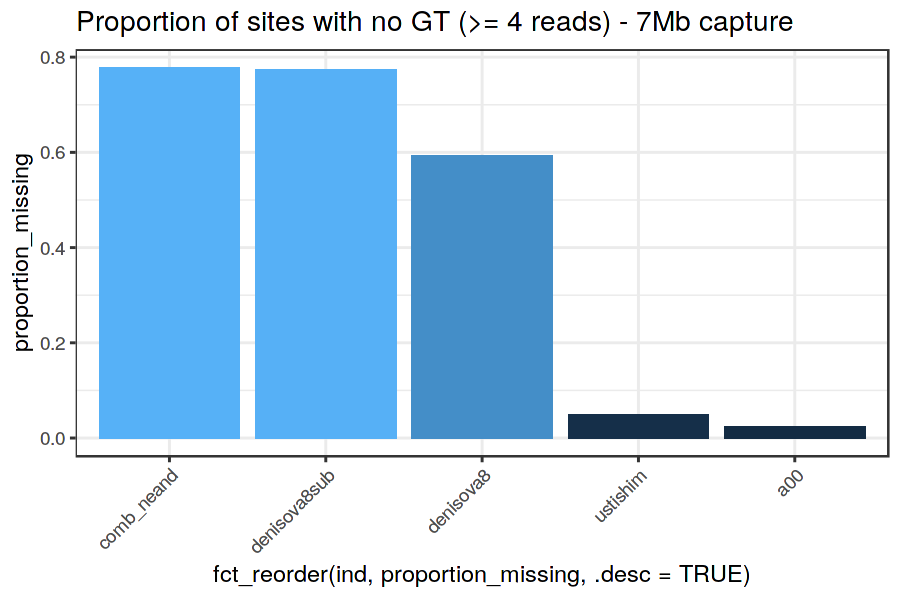

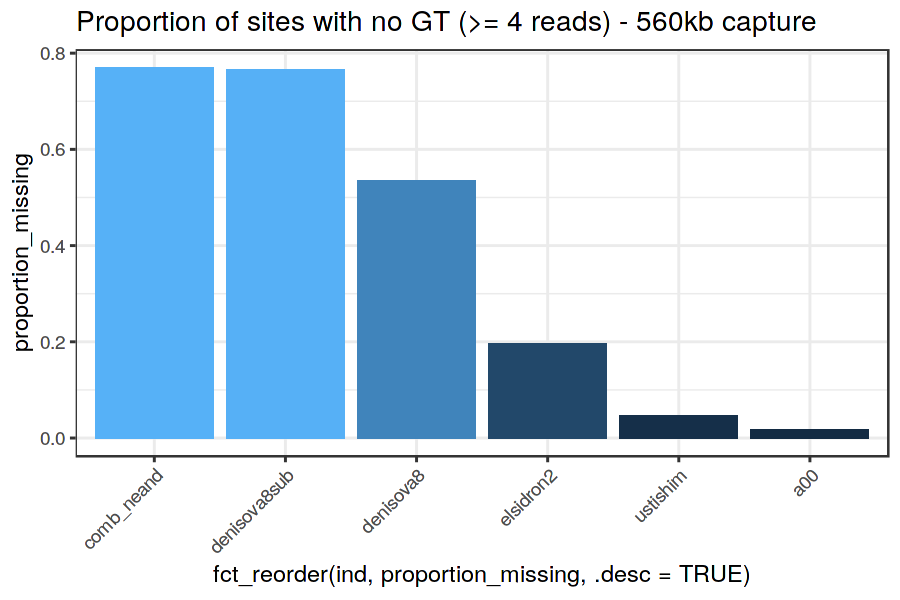

In [6]:
set_dim(6, 4)

select(full_gt, -c(chrom, pos, REF, ALT)) %>%
summarise_all(~ mean(is.na(.), na.rm = TRUE)) %>%
gather(ind, proportion_missing) %>%
ggplot(aes(fct_reorder(ind, proportion_missing, .desc = TRUE), proportion_missing, fill = proportion_missing)) +
    geom_bar(stat = "identity") +
    ggtitle("Proportion of sites with no GT (>= 4 reads) - 7Mb capture") +
    theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45))

select(lippold_gt, -c(chrom, pos, REF, ALT)) %>%
summarise_all(~ mean(is.na(.), na.rm = TRUE)) %>%
gather(ind, proportion_missing) %>%
ggplot(aes(fct_reorder(ind, proportion_missing, .desc = TRUE), proportion_missing, fill = proportion_missing)) +
    geom_bar(stat = "identity") +
    ggtitle("Proportion of sites with no GT (>= 4 reads) - 560kb capture") +
    theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45))

In [7]:
exome_props <- snp_props(exome_gt)
lippold_props <- snp_props(lippold_gt)
full_props <- snp_props(full_gt)

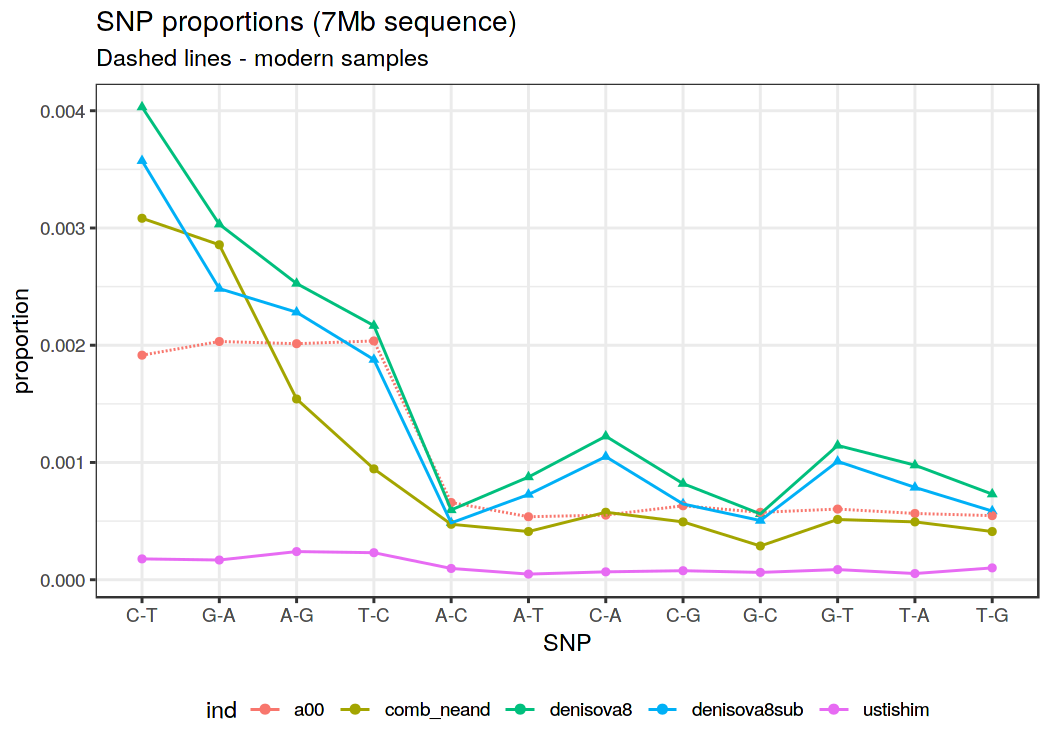

In [8]:
set_dim(7, 5)

full_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point(aes(shape = ind %in% c("denisova8", "denisova8sub"))) +
    geom_line(aes(group = ind, linetype = str_detect(ind, "S_|a00"))) +
    theme_bw() +
    guides(linetype = FALSE, shape = FALSE) +
    xlab("SNP") +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions (7Mb sequence)",
            "Dashed lines - modern samples")

* A00 completely overlaps the combined Mez2-Spy1 Y chromosome?!


TODO: subsample Den8 to the comb_nead coverage

Warning message:
“Unknown levels in `f`: C-T, G-A, A-G, T-C”Warning message:
“Unknown levels in `f`: C-T, G-A, A-G, T-C”Warning message:
“Unknown levels in `f`: C-T, G-A, A-G, T-C”

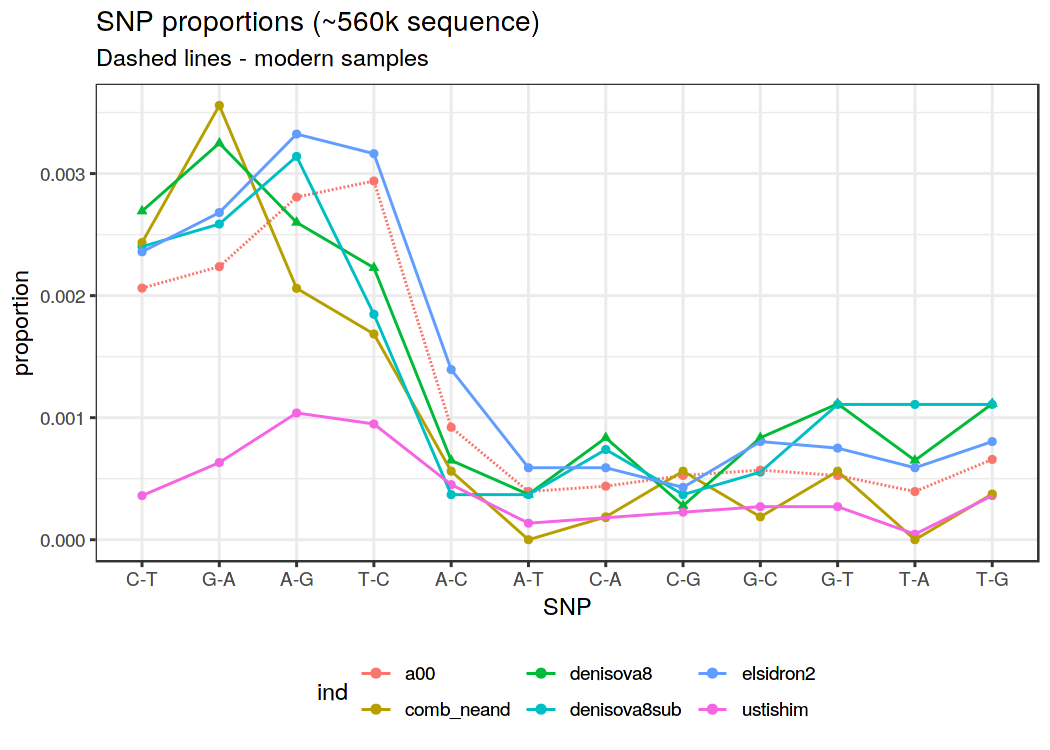

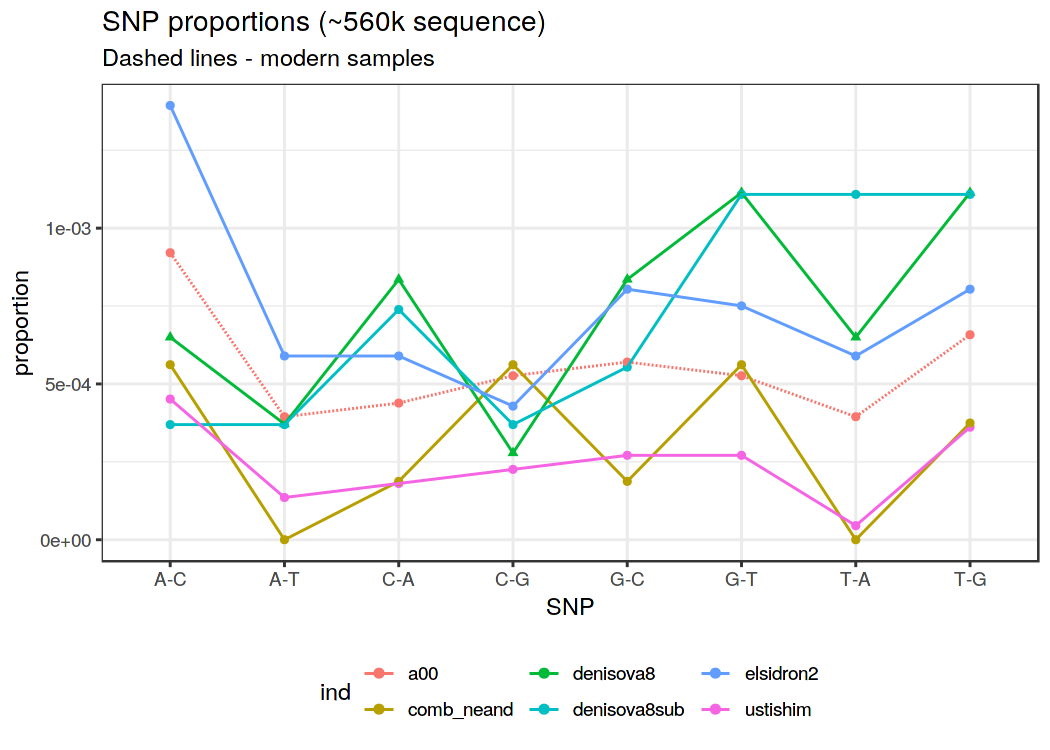

In [9]:
set_dim(7, 5)

lippold_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point(aes(shape = ind %in% c("denisova8"))) +
    geom_line(aes(group = ind, linetype = str_detect(ind, "S_|a00"))) +
    theme_bw() +
    guides(linetype = FALSE, shape = FALSE) +
    xlab("SNP") +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions (~560k sequence)",
            "Dashed lines - modern samples")

lippold_props %>%
gather(ind, proportion, -snp) %>%
filter(snp %notin% c("C-T", "G-A", "A-G", "T-C")) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point(aes(shape = ind %in% c("denisova8"))) +
    geom_line(aes(group = ind, linetype = str_detect(ind, "S_|a00"))) +
    theme_bw() +
    guides(linetype = FALSE, shape = FALSE) +
    xlab("SNP") +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions (~560k sequence)",
            "Dashed lines - modern samples")

# Testing the coverage cutoff for Denisova 8

In [61]:
test_cov <- read_gt(here("data/vcf/test_cov.vcf.gz"), var_only = TRUE) %>% select(-reference)

In [62]:
set_dim(6, 4)

test_missing <-
    select(test_cov, -c(chrom, pos, REF, ALT)) %>%
    summarise_all(~ mean(is.na(.), na.rm = TRUE)) %>%
    gather(ind, proportion_missing)

test_missing

ind,proportion_missing
a00,0.02345241
S_French_1,0.01139896
denisova8sub,0.96863921
denisova8_dp1,0.03708754
denisova8_dp2,0.80902645
denisova8_dp3,0.89885465
denisova8_dp4,0.93662394
denisova8_dp5,0.96195800
denisova8_dp6,0.97752932
denisova8_dp7,0.98808290


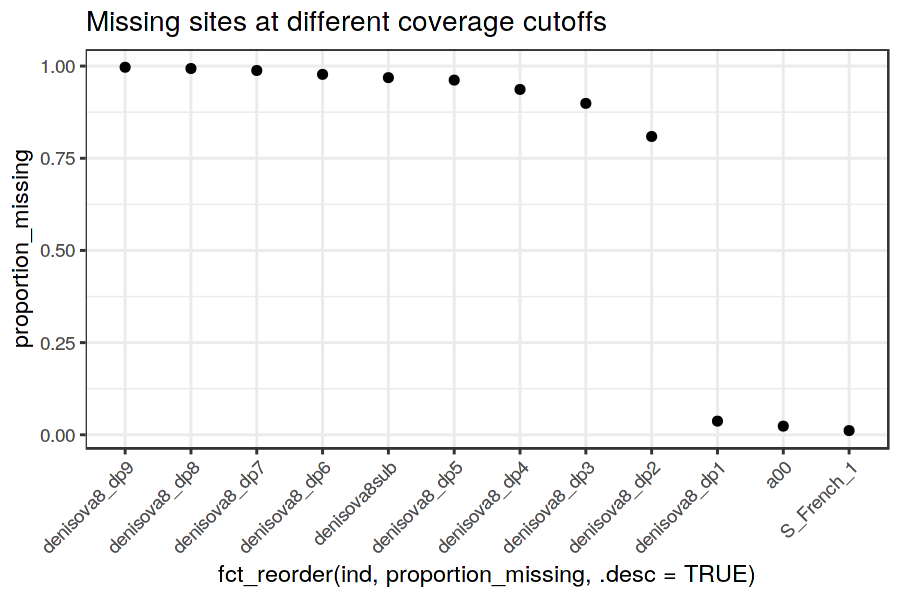

In [66]:
set_dim(6, 4)

test_missing %>%
ggplot(aes(fct_reorder(ind, proportion_missing, .desc = TRUE), proportion_missing, fill = proportion_missing)) +
    geom_point() +
    ggtitle("Missing sites at different coverage cutoffs") +
    theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45))

In [74]:
test_props <- snp_props(test_cov)

* C-T x T-C, G-A x A-G equal in A00
* not so in Denisova, but C-T/G-A goes down a lot with increasing coverage consensus cutoff (note that increasing the cutoff decreases the # of sites significantly => data more noisy)
* would be great to repeat this analysis with some high coverage nonUDG EMH male individual

## Proportions of SNPs normalized vs the proportion of T-C SNPs in each sample

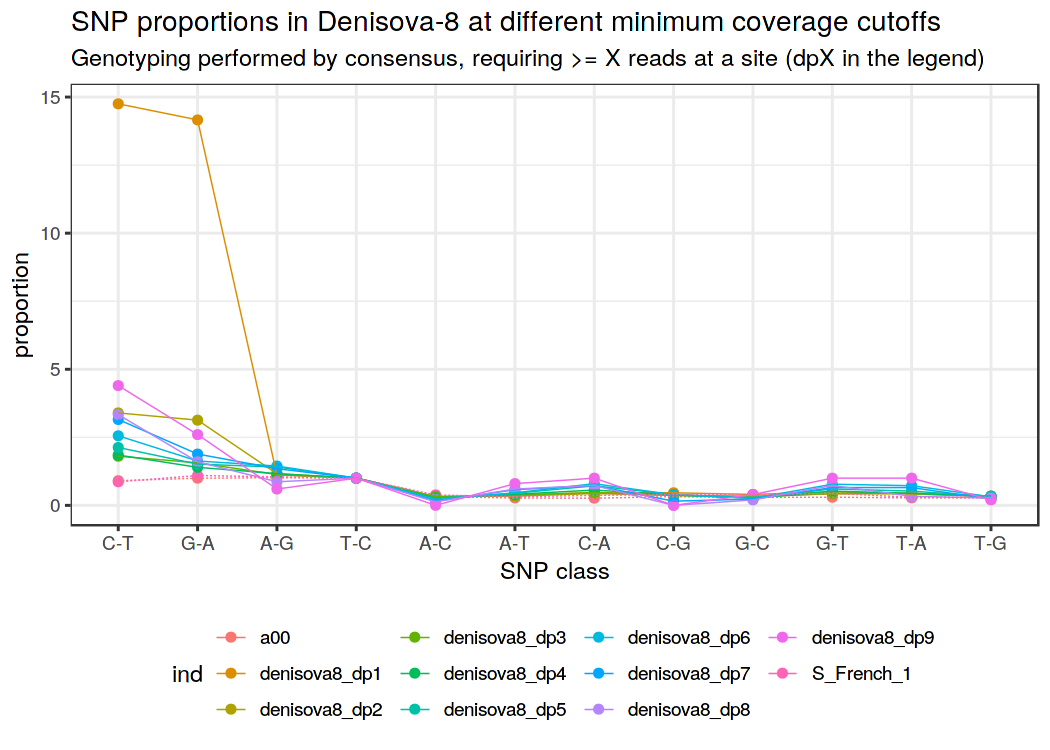

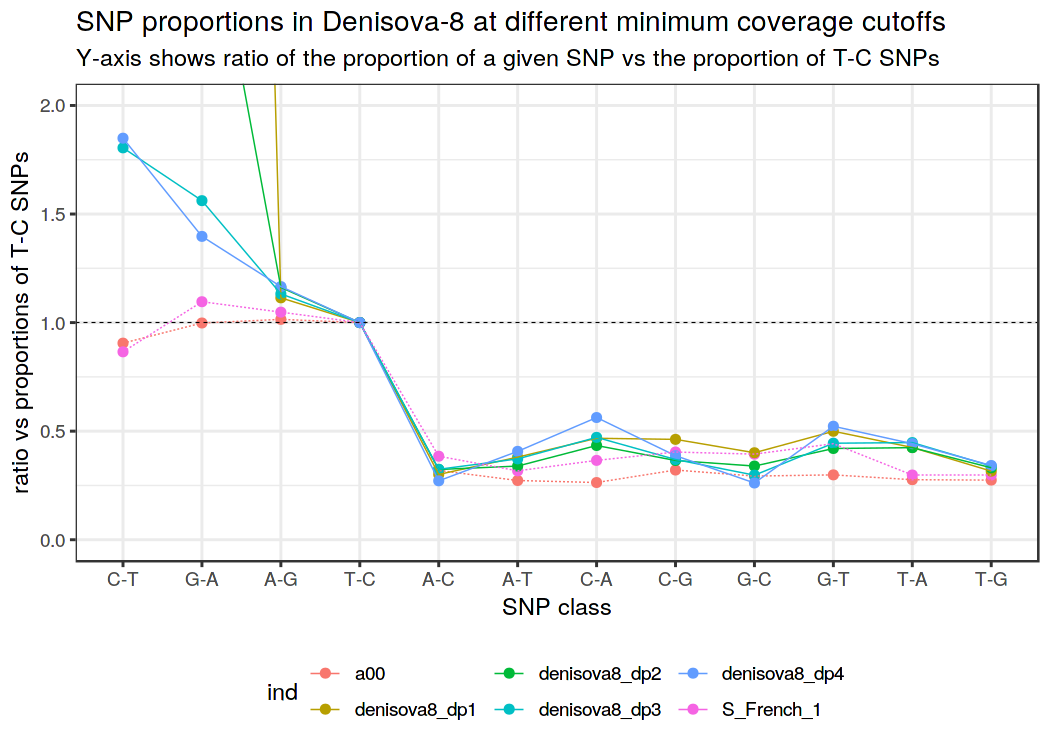

In [78]:
set_dim(7, 5)

test_props %>%
gather(ind, proportion, -snp) %>% filter(!str_detect(ind, "sub")) %>% 
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = ind %in% c("S_French_1", "a00")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different minimum coverage cutoffs",
            "Genotyping performed by consensus, requiring >= X reads at a site (dpX in the legend)")

test_props %>%
gather(ind, proportion, -snp) %>%
    filter(!str_detect(ind, "sub"), ind %in% c("S_French_1", "a00", paste0("denisova8_dp", 1:4))) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = ind %in% c("S_French_1", "a00")), size = 0.25) +
    theme_bw() + ylab("ratio vs proportions of T-C SNPs") +
    xlab("SNP class") + geom_hline(yintercept = 1, linetype = 2, size = 0.2) +
    guides(linetype = FALSE) +
    theme(legend.position = "bottom") +
    coord_cartesian(y = c(0, 2)) +
    ggtitle("SNP proportions in Denisova-8 at different minimum coverage cutoffs",
            "Y-axis shows ratio of the proportion of a given SNP vs the proportion of T-C SNPs")

# Add binomial confidence intervals!

In [35]:
read_dp <- function(name, path, dp) {
    read_gt(path, mindp = dp, var_only = TRUE) %>%
        .[, c("chrom", "pos", name)] %>%
        setNames(c("chrom", "pos", name %+% "_dp" %+% dp))
}

In [38]:
den8_gt <- bind_cols(
    read_dp("denisova8", here("data/vcf/merged_full.vcf.gz"), dp = 1),
    map(2:5, ~ read_dp("denisova8", here("data/vcf/merged_full.vcf.gz"), dp = .x) %>% select(-chrom, -pos))
)

In [39]:
neand_gt <- bind_cols(
    read_dp("comb_neand", here("data/vcf/merged_full.vcf.gz"), dp = 1),
    map(2:5, ~ read_dp("comb_neand", here("data/vcf/merged_full.vcf.gz"), dp = .x) %>% select(-chrom, -pos))
)

In [42]:
lowcov_gt <- inner_join(den8_gt, neand_gt, by = c("chrom", "pos"))

In [43]:
highcov_gt <- read_gt(here("data/vcf/merged_full.vcf.gz")) %>%
    select(chrom, pos, REF, ALT, a00, S_French_1, S_Dinka_1)

In [45]:
gt <- inner_join(highcov_gt, lowcov_gt)

Joining, by = c("chrom", "pos")


In [46]:
test_props <- snp_props(gt)

In [ ]:
set_dim(7, 5)

test_props %>%
gather(ind, proportion, -snp) %>% filter(!str_detect(ind, "sub"), !str_detect(ind, "neand")) %>% 
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = ind %in% c("S_French_1", "a00")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different minimum coverage cutoffs",
            "Genotyping performed by consensus, requiring >= X reads at a site (dpX in the legend)")

test_props %>%
gather(ind, proportion, -snp) %>% filter(ind %in% c("S_French_1", "a00", paste0("denisova8_dp", 1:4))) %>% 
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = ind %in% c("S_French_1", "a00")), size = 0.25) +
    theme_bw() + ylab("ratio vs proportions of T-C SNPs") +
    xlab("SNP class") + geom_hline(yintercept = 1, linetype = 2, size = 0.2) +
    guides(linetype = FALSE) +
    theme(legend.position = "bottom") +
    coord_cartesian(y = c(0, 2)) +
    ggtitle("SNP proportions in Denisova-8 at different minimum coverage cutoffs",
            "Y-axis shows ratio of the proportion of a given SNP vs the proportion of T-C SNPs")